# Sequence - To - Sequence

In [ ]:
# ! pip install torchtext==0.6.0

In [ ]:
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"

# ! pip install -U spacy
# ! python -m spacy download fr_core_news_sm
# ! python -m spacy download en_core_web_sm

In [1]:
import torch
import torchtext

import numpy as np
import pandas as pd
import spacy
import time
import random

import matplotlib.pyplot as plt
import IPython.display as display
from collections import defaultdict


2023-07-04 00:47:54.014584: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-04 00:47:54.099702: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-04 00:47:54.427141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-07-04 00:47:54.427172: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
if torch.backends.mps.is_available():
    DEVICE = torch.device(device='mps')
elif torch.cuda.is_available():
    DEVICE = torch.device(device='cuda')
else:
    DEVICE = torch.device(device='cpu')

In [3]:
print(DEVICE)

cuda


### Preprocessing

In [4]:
spacy_en = spacy.load('en_core_web_sm')
spacy_fr = spacy.load('fr_core_news_sm')

In [5]:
french = torchtext.data.Field(tokenize= lambda text: [token.text for token in spacy_en.tokenizer(text)],
                              lower = True,
                              init_token = '<sos>',
                              eos_token = '<eos>')

english = torchtext.data.Field(tokenize= lambda text: [token.text for token in spacy_fr.tokenizer(text)],
                              lower = True,
                              init_token = '<sos>',
                              eos_token = '<eos>')

In [6]:
fields = {
    'English': ('eng', english),
    'French': ('fre', french)

}

train_data, test_data = torchtext.data.TabularDataset.splits(
    path='data/',
    train='train_full.csv',
    test = 'test_full.csv',
    format='csv',
    fields=fields
)

In [7]:
english.build_vocab(train_data, max_size = 10000, min_freq = 2)
french.build_vocab(train_data, max_size = 10000, min_freq = 2)

In [8]:
batch_size = 64
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (train_data, test_data),
    batch_size = batch_size,
    sort_within_batch = True, # Protizes to have examples are of similar length in a batch, because it reduces padding and save compute.
    sort_key = lambda x: len(getattr(x, 'eng')), # Protizes to have examples are of similar length in a batch, because it reduces padding and save compute.
    device=DEVICE
)

### Learning Loops

In [9]:
pad_idx = french.vocab.stoi['<pad>']
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

In [10]:
def one_epoch_train(model: torch.nn.Module, data_loader_train: torch.utils.data.DataLoader,
                    loss_criterion: torch.nn, optim_alog: torch.optim) -> tuple:
    """Function that trains the model for one epoch.

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        tuple: Tuple carrying Train loss and accuracy
    """
    batch_loss_train = []
    batch_counter = 0
    for batch in data_loader_train:
        input_text = batch.eng.to(DEVICE).permute(1,0)
        target_text = batch.fre.to(DEVICE).permute(1,0)


        # Enabling model training.
        model.train(True)


        #Setting gradients to zero to prevent gradient accumulation.
        optim_alog.zero_grad()

        # Forward pass.
        y_pred_prob = model(input_text, target_text)
        
        y_pred_prob = y_pred_prob[:,1:,:].reshape(-1, y_pred_prob.shape[2])
        target_text = target_text[:, 1:].reshape(-1)

        loss = loss_criterion(y_pred_prob, target_text)

        batch_loss_train.append(loss.item())

        # Back Propagation
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        # Updating weights
        optim_alog.step()
        
        batch_counter += 1

        del(input_text)
        del(target_text)

    return sum(batch_loss_train)/batch_counter

In [11]:
def inference(model: torch.nn.Module, data_loader_val: torch.utils.data.DataLoader, loss_criterion: torch.nn) -> tuple:
    """Function that calculates test accuracy

    Args:
        model (torch.nn.Module): Pytorch model we want to make inference on.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.

    Returns:
        tuple: Tuple carrying Test loss and accuracy
    """

    batch_loss_train = []
    batch_counter = 0

    for batch in data_loader_val:
        input_text = batch.eng.to(DEVICE).permute(1,0)
        target_text = batch.fre.to(DEVICE).permute(1,0)

        # Disabiling model training.
        model.train(False)

        with torch.inference_mode():
            # Forward Pass
            y_pred_prob = model(input_text, target_text)

            y_pred_prob = y_pred_prob[:,1:,:].reshape(-1, y_pred_prob.shape[2])
            target_text = target_text[:, 1:].reshape(-1)

            # Calculating Loss
            loss = loss_criterion(y_pred_prob, target_text)
            batch_loss_train.append(loss.item())

        batch_counter += 1

        del(input_text)
        del(target_text)

    return sum(batch_loss_train)/batch_counter

In [12]:
def training_loop(
    model: torch.nn.Module,
    data_loader_train: torch.utils.data.DataLoader,
    data_loader_val: torch.utils.data.DataLoader,
    epochs:int,
    loss_criterion: torch.nn,
    optim_alog: torch.optim,
    chkpt_file:str,
    final_load_file:str
)-> dict:
    """Function that trains the model for the given number of epochs

    Args:
        model (torch.nn.Module): Pytorch model we want to train.
        data_loader_train (torch.utils.data.DataLoader): Pytorch dataloader that carries training data.
        data_loader_val (torch.utils.data.DataLoader): Pytorch dataloader that carries validation data.
        epochs (int): Count of EPOCHS
        loss_criterion (torch.nn): Pytorch loss criteria on which we calculate loss.
        optim_alog (torch.optim): Opimiztion algoritham that we use to update model weights.

    Returns:
        dict: A dictionary that carries the output metrics.
    """
    start_time = time.time()

    loss_train = []
    loss_val = []
    
    best_loss_val = 1e5
    # Loop that iterates over each EPOCH
    for epoch in range(epochs):

        #Train the model for one EPOCH
        epoch_loss = one_epoch_train(model, data_loader_train, loss_criterion, optim_alog)
        loss_train.append(epoch_loss)

        # Caluclating Testing results
        val_loss = inference(model, data_loader_val, loss_criterion)
        loss_val.append(val_loss)

        if val_loss < best_loss_val:
            best_loss_val = val_loss
            torch.save(model.state_dict(), chkpt_file)

        if (epoch+1)%1 == 0:
            print('For Epoch {} We Train Loss:{:.4f}, Val Loss:{:.4f}, Time Elapsed:{:.4f} mins'.format(epoch+1, epoch_loss,val_loss, (time.time() - start_time)/60))
            
    torch.save(model.state_dict(), final_load_file)
    return {'training_loss':loss_train, 'val_loss':loss_val}

In [13]:
def plot_metrics(epochs: int,metrics: dict) -> None:
    """Plot the graphs of Training and Testing Accuracy and Loss across Epoches

    Args:
        epochs (int): Number of Epochs
        metrics (dict): A dictionary containing Test and Training datasets' Loss and accuracy
    """

    plt.figure(figsize=(10,10))
    plt.plot(list(range(epochs)), metrics['training_loss'])
    plt.plot(list(range(epochs)), metrics['val_loss'])
    plt.grid()
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation loss across epochs')

    plt.show()

In [14]:
def sentence_translator(model: torch.nn.Module, sentence: str, src_corpus: torchtext.data.Field, tgt_corpus: torchtext.data.Field) -> list:
    """Given the model and english sentence it will translate the english sentence to french.

    Args:
        model (torch.nn.Model): Pytorch Model
        sentence (str): English sentence
        src_corpus (torchtext.data.Field): English Corpus (Source Torchtext data field)
        tgt_corpus (torchtext.data.Field): French Corpus (Destination Torchtext data field)

    Returns:
        list: List of words 
    """
    
    # Checking If the sentence is string or not.
    if isinstance(sentence, str):
        tokens = [token.text.lower() for token in spacy_en(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    # Attaching <SOS> token at the beginning of the source sentence
    tokens.insert(0, src_corpus.init_token)
    
    # Attaching <EOS> token at the end of the source sentence
    tokens.append(src_corpus.eos_token)
    
    # Converting the soruce text to sentence vector 
    sentence_vector =[]
    for token in tokens:
        sentence_vector.append(src_corpus.vocab.stoi[token])
        
    # Creating a tensor from the vector
    sentence_tensor = torch.tensor(sentence_vector, dtype=torch.long).unsqueeze(1).to(DEVICE).permute(1,0)
    
    # Performing encoding
    with torch.inference_mode():
        hidden_state, cell_state = model.encoder(sentence_tensor)
        
    # Attaching <SOS> token at the beginning of the destination sentence. 
    outputs = [tgt_corpus.vocab.stoi["<sos>"]]
    
    # Iteration over and producing the sequnce of words of the translated sentence. 
    for _ in range(30):
        
        # Getting previous word to pass it to decoder
        prev_word = torch.tensor([outputs[-1]], dtype=torch.long).to(DEVICE)
        
        # Performing Decoding
        with torch.inference_mode():
            output, hidden_state, cell_state = model.decoder(prev_word, hidden_state, cell_state)
            # Predicting the word
            word_pred = torch.argmax(output, axis=1).item()
            
        # Append the Predicted word 
        outputs.append(word_pred)
        
        # On reaching end of the sentence break the loop
        if word_pred == tgt_corpus.vocab.stoi["<eos>"]:
            break
    
    # Converting translated sentence vector to translated sentence.
    translated_sentence = []
    for idx in outputs:
        translated_sentence.append(tgt_corpus.vocab.itos[idx])

    return translated_sentence[1:-1]

In [15]:
def score_bleu(dataset: torchtext.data.TabularDataset.splits, model: torch.nn.Module, src_corpus: torchtext.data.Field, tgt_corpus: torchtext.data.Field) -> int:
    """ Get BLeU score of the given dataset and its translation.

    Args:
        dataset (torchtext.data.TabularDataset.splits): torch text data set
        model (torch.nn.Model): pytorch model
        src_corpus (torchtext.data.Field): English Corpus (Source Torchtext data field)
        tgt_corpus (torchtext.data.Field): French Corpus (Destination Torchtext data field)

    Returns:
        int: Bleu score of the translation.
    """
    targets = []
    outputs = []

    for translation_record in dataset:
        source_sentence = vars(translation_record)["eng"]
        target_sentence = vars(translation_record)["fre"]

        translated_sentence = sentence_translator(model, source_sentence, src_corpus, tgt_corpus)

        targets.append([target_sentence])
        outputs.append(translated_sentence)

    return torchtext.data.metrics.bleu_score(outputs, targets)

In [16]:
def score_bleu_by_length(
    dataset: torchtext.data.TabularDataset.splits,
    model: torch.nn.Module,
    src_corpus: torchtext.data.Field,
    tgt_corpus: torchtext.data.Field
) -> dict:
    """ Get BLeU score of the given dataset and its translation.

    Args:
        dataset (torchtext.data.TabularDataset.splits): torch text data set
        model (torch.nn.Model): pytorch model
        src_corpus (torchtext.data.Field): English Corpus (Source Torchtext data field)
        tgt_corpus (torchtext.data.Field): French Corpus (Destination Torchtext data field)

    Returns:
        dict: Bleu score of the translation.
    """
    data_map = {}

    for translation_record in dataset:
        source_sentence = vars(translation_record)["eng"]
        target_sentence = vars(translation_record)["fre"]

        translated_sentence = sentence_translator(model, source_sentence, src_corpus, tgt_corpus)
        
        src_length = len(source_sentence)
        
        if data_map.get(src_length) is None:
            data_map[src_length] = {
                "targets": [],
                "outputs": []
            }

        data_map[src_length]["targets"].append([target_sentence])
        data_map[src_length]["outputs"].append(translated_sentence)
    
    results = {
        "length": [],
        "count": [],
        "bleu_score": []
    }
    for length, data in data_map.items():
        bleu_score = torchtext.data.metrics.bleu_score(data["outputs"], data["targets"])
        
        results["length"].append(length)
        results["count"].append(len(data["targets"]))
        results["bleu_score"].append(bleu_score)
        
    return results 

## Model Building

#### Encoder

In [17]:
class Encoder(torch.nn.Module):
    """
    Encode the original sentence to context vector
    
    Args:
        input_size (int): Input Dimension
        embedding_size (int): Word Embedding Size
        hidden_size (int): RNN Output Size
        num_layers (int): Num of Layers of RNN
        droput_prob (float): Dropout Probability
    """
    def __init__(
        self,
        input_size: int,
        embedding_size: int,
        hidden_size: int,
        num_layers: int,
        droput_prob: float
    ):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.dropout = torch.nn.Dropout(droput_prob)
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        self.lstm = torch.nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=droput_prob)

    def forward(self, x):
        word_embedding = self.dropout(self.embedding(x))

        _ , (hidden_state, cell_state) = self.lstm(word_embedding)

        return hidden_state, cell_state

#### Decoder

In [18]:
class Decoder(torch.nn.Module):
    """
    Decode the context vector to target sentence word by word
    
    Args:
        input_size (int): Input Dimension
        embedding_size (int): Word Embedding Size
        hidden_size (int): RNN Output Size
        output_size (int): Target language Vocab Size
        num_layers (int): Num of Layers of RNN
        droput_prob (float): Dropout Probability
    """
    def __init__(
        self,
        input_size: int,
        embedding_size: int,
        hidden_size: int,
        output_size: int,
        num_layers: int,
        droput_prob: float
    ):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.droput = torch.nn.Dropout(droput_prob)
        self.embedding = torch.nn.Embedding(input_size, embedding_size)

        self.lstm = torch.nn.LSTM(embedding_size, hidden_size, num_layers, batch_first=True, dropout=droput_prob)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden_state, cell_state):
        x = x.unsqueeze(1)

        word_embedding = self.droput(self.embedding(x))
        
        output, (hidden_state, cell_state) = self.lstm(word_embedding, (hidden_state, cell_state))

        pred = self.linear(output)        
        pred = pred.squeeze(1)
     
        return pred, hidden_state, cell_state

#### Seq-2-Seq

In [19]:
class Seq2Seq(torch.nn.Module):
    """
    Takes Src texts and translates into target word by word
    
    Args:
        input_size_encoder (int): Encoder Input Dimension
        encoder_embedding_size (int): Encoder Word Embedding Size
        input_size_decoder (int): Decoder Input Dimension
        decoder_embedding_size (int): Decoder Word Embedding Size
        hidden_size (int): RNN Output Size
        output_size (int): Target language Vocab Size
        num_layers (int): Num of Layers of RNN
        encoder_dropout (float): Encoder Dropout Probability
        decoder_dropout (float): Decoder Dropout Probability
        word_alignment_ratio(float): Word Alignment Ratio
    """
    def __init__(
        self,
        input_size_encoder: int,
        encoder_embedding_size: int,
        input_size_decoder: int ,
        decoder_embedding_size: int,
        hidden_size: int, 
        num_layers: int,
        output_size: int,
        encoder_dropout: float,
        decoder_dropout: float,
        word_alignment_ratio=0.6
    ):
        
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(
            input_size_encoder,
            encoder_embedding_size,
            hidden_size, num_layers,
            encoder_dropout
        ).to(DEVICE)
        
        self.decoder = Decoder(
            input_size_decoder,
            decoder_embedding_size,
            hidden_size,
            output_size,
            num_layers,
            decoder_dropout
        ).to(DEVICE)
        
        # Probability Mass Function defined for the word_selection we should choose
        self.next_word_selection_actions = [
            'Guess',
            'Truth'
        ]
        self.next_word_selection_probability_distribution = [
            word_alignment_ratio,
            1 - word_alignment_ratio
        ]

    def forward(self, src_text, tgt_text):

        batch_size = src_text.shape[0]
        target_len = tgt_text.shape[1]
        target_vocab_size = len(french.vocab)

        outputs = torch.zeros(batch_size, target_len,target_vocab_size).to(device=DEVICE)

        hidden_state, cell_state = self.encoder(src_text)
        
        # Grab Start Token
        x = tgt_text[:, 0]

        for t in range(1, target_len):
            output, hidden_state, cell_state = self.decoder(x, hidden_state, cell_state)
            outputs[:, t, :] = output
            
            # Sampling type word to select based on the above defined Probability Mass Function.
            word_to_choose = np.random.choice(
                a = self.next_word_selection_actions,
                size=1, 
                p=self.next_word_selection_probability_distribution
            )
            
            if word_to_choose == 'Guess':
                x = torch.argmax(output, dim=1)
            else:
                x = tgt_text[:,t]

        return outputs

In [20]:
seq_2_seq_model = Seq2Seq(
    input_size_encoder=len(english.vocab),
    encoder_embedding_size = 300, 
    input_size_decoder = len(french.vocab),
    decoder_embedding_size = 300,
    hidden_size = 512, 
    num_layers = 2,
    output_size = len(french.vocab),
    encoder_dropout = 0.5,
    decoder_dropout = 0.5
).to(DEVICE)

In [21]:
chkpt_file = 'saved_files/s2s_best.pt'
final_load_file = 'saved_files/s2s_final.pt'

In [22]:
EPOCHS = 50
optimizer = torch.optim.Adam(seq_2_seq_model.parameters(), lr=3e-4)

In [23]:
output_metrics = training_loop(
    model = seq_2_seq_model,
    data_loader_train = train_iterator,
    data_loader_val = test_iterator,
    epochs = EPOCHS, 
    loss_criterion = criterion, 
    optim_alog = optimizer,
    chkpt_file = chkpt_file,
    final_load_file = final_load_file
)

For Epoch 1 We Train Loss:4.6696, Val Loss:3.9323, Time Elapsed:2.2641 mins
For Epoch 2 We Train Loss:3.7319, Val Loss:3.3810, Time Elapsed:4.5380 mins
For Epoch 3 We Train Loss:3.2961, Val Loss:3.0283, Time Elapsed:6.8776 mins
For Epoch 4 We Train Loss:2.9998, Val Loss:2.7847, Time Elapsed:9.1744 mins
For Epoch 5 We Train Loss:2.7730, Val Loss:2.6188, Time Elapsed:11.4505 mins
For Epoch 6 We Train Loss:2.5886, Val Loss:2.4760, Time Elapsed:13.7190 mins
For Epoch 7 We Train Loss:2.4462, Val Loss:2.3592, Time Elapsed:16.0002 mins
For Epoch 8 We Train Loss:2.3204, Val Loss:2.2901, Time Elapsed:18.2890 mins
For Epoch 9 We Train Loss:2.2135, Val Loss:2.2349, Time Elapsed:20.5445 mins
For Epoch 10 We Train Loss:2.1238, Val Loss:2.1655, Time Elapsed:22.8688 mins
For Epoch 11 We Train Loss:2.0472, Val Loss:2.1034, Time Elapsed:25.1187 mins
For Epoch 12 We Train Loss:1.9717, Val Loss:2.0860, Time Elapsed:27.3953 mins
For Epoch 13 We Train Loss:1.9072, Val Loss:2.0552, Time Elapsed:29.6483 mins

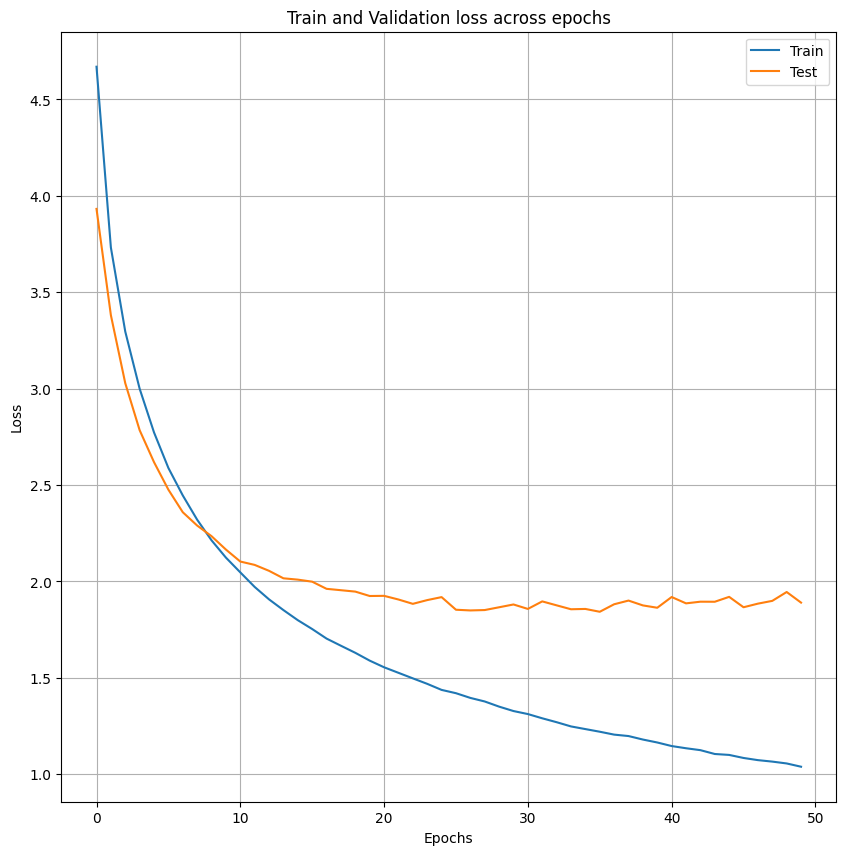

In [24]:
plot_metrics(EPOCHS, output_metrics)

In [25]:
print('Test BLEU Score:{0}'.format(score_bleu(test_data, seq_2_seq_model, english, french)))

Test BLEU Score:0.36962331465309584


In [28]:
metrics_df = pd.DataFrame(output_metrics)
metrics_df.to_csv('saved_files/s2s_metrics.csv')

In [29]:
bleu_score_results = score_bleu_by_length(test_data, seq_2_seq_model, english, french)
bleu_score_results_df = pd.DataFrame(bleu_score_results)
bleu_score_results_df.to_csv('saved_files/s2s_bleu.csv')

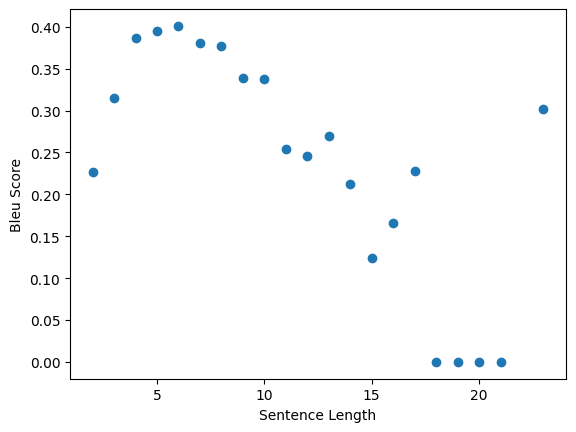

In [30]:
plt.figure()
plt.scatter(bleu_score_results_df["length"], bleu_score_results_df["bleu_score"])
plt.ylabel("Bleu Score")
plt.xlabel("Sentence Length")
plt.show()

In [ ]:
# print('Train BLEU Score:{0}'.format(score_bleu(train_data, seq_2_seq_model, english, french)))